In [1]:
#Importing Libraries
import saha_mult #Class used to calculate abundances 
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import scipy.constants as sc
from time import process_time #Useful for finding calculation times
import pickle #for saving data in lists to txt files.

import importlib 
importlib.reload(saha_mult) #This command ensures that any changes made to saha_mult class are reflected in this notebook


<module 'saha_mult' from 'C:\\Users\\prana\\Documents\\Research\\R-process_Mergers\\Abundance_Calculations\\Total Charge State Abundances\\saha_mult.py'>

In [2]:
#Read in data for ionization potentials and skynet stuff
#Note that the NIST data table includes many elements that just skip ionization potentials, so I set a cutoff at Lr.
nist = pd.read_excel("NIST Data Table.xlsx")
hf = h5py.File("SkyNet_r-process.h5")

In [3]:
#This function here will return all the ionization potentials of the desired elements. Enter the starting element and
#ending element Z number. This will return an array of arrays. Note the starting position of the array!

#The way I did this was similar to the Multiple Elements Scenario code, but I added an extra array called 
#returned_potentials, which is designed to return an array of all the desired potentials we wanted
ion_energies1d =  nist[' Ionization  Energy (eV)']

def ionization_generator(elements):
    max_el = 103 #This is defined to be the Z of the last element that I want in the list 
    ion_energies = list()
    returned_potentials = list()
    counter = 0

    for i in range(0,max_el+1):
        specific_list = list()

        for j in range(i):

            if isinstance(ion_energies1d[counter],str):

                if len(ion_energies1d[counter]) ==3:
                    specific_list.append(0)
                    counter+=1
                else:
                    str_num = '' 

                    for k in ion_energies1d[counter]:

                        if (k != ' ') and (k !='[') and (k !=']') and (k !='(') and (k !=')'):
                            str_num+=k

                    specific_list.append(np.abs(float(str_num)))
                    counter+=1


            else:
                specific_list.append(np.array((np.abs(ion_energies1d[counter]))))
                counter+=1

        ion_energies.append(specific_list)
    ion_energies[-1][-2] = np.average([ion_energies[-1][-1],ion_energies[-1][-3]])
        
    for i in range(len(elements)):
        returned_potentials.append(np.array((ion_energies[elements[i]])))        
        
    return np.array(returned_potentials)

In [4]:
#This cell is simply for temperature, and since it does not change no matter the elements used, I do not use a function
#At some point, I will have to find a way to find the places to calculate the indices to use to find slope for other hdf5s
temperature = hf["Temperature"]
time = hf["Time"]
mod_temp = []
full_temp = []

linear = np.polyfit(np.log10(np.array(time[900:1700])),np.log10(np.array(temperature[900:1700])),1)
m = linear[0]

for i in range(0,len(temperature)):
    if i < 1700:
        mod_temp.append(np.log10(temperature[i]))
        full_temp.append(temperature[i])
    else:
        del_t = m*(np.log10(time[i]) - np.log10(time[i-1]))
        mod_temp.append(mod_temp[i-1]+del_t)
        full_temp.append(10**mod_temp[i])

In [5]:
#initialization of ionization potentials and full abundances from Skynet
#used in the abundance calculation function
abundance = hf["Y"]
charge = hf["Z"]
density = hf["Density"]
Ye_tot = hf['Ye']
kbEvpGK = 8.617e-5*1e9

def initialization(elements):

    full_abundance = []
    ion_potential = ionization_generator(elements)
    
    for i in range(len(elements)):
        temp_index = []
        temp_abundance = []
        
        for j in range(len(charge)):
            
            if charge[j] == (elements[i]): ##charge of element
                temp_index.append(j)
                
        temp_abundance = np.sum(abundance[:, temp_index], 1)
        full_abundance.append(temp_abundance)
        
    return np.array(full_abundance),np.array(ion_potential)

In [6]:
#Abundance function
def abundance_calculation(elements):
    x,y = initialization(elements)
    return (saha_mult.GetAbundances(x,np.array(full_temp),np.array(density),y))

In [7]:
#Function to plot the abundances, the sum of all ionization states, and the graphical check
#At some point, I might add functionality to choosing which things to graph

#1 hr = 3600 sec
#2 Weeks = 1.21e+6 seconds

def plotter(abun):
    
    time_start = process_time()
    #colors = ['r','b'] #Just a color scheme to indicate varying elements instead of having too many colors.
    x = np.zeros((len(abun[0]),len(abun[-1][0]))) #Initializing the array useful in tracking ionization state abundances
    checksum = []#Another way to calculating the total sum across time. 
    index_total = [] #Calculating total sum across time 
       
    #Plotting abundances vs Temp
    for Y in abun:
        Ytot = np.sum(Y,1)
        for i in range(len(Y[0])):
            plt.semilogx(kbEvpGK*np.array(full_temp),(Y[:,i])/Ytot,)
            plt.xlabel("Temperature(eV)")
            plt.ylabel("Rel. Abundance")
            plt.title("Rel. Abundances of Elements in Mixture vs Temperature")
    
    plt.show()
    
    
    #Plotting abundances vs Time
    for Y in abun:
        Ytot = np.sum(Y,1)
        for i in range(len(Y[0])):
            plt.semilogx(time,(Y[:,i])/Ytot,)
            plt.xlabel("Time(sec)")
            plt.ylabel("Rel. Abundance")
            plt.title("Rel. Abundances of Elements in Mixture vs Time")
    
    plt.show()
    
    
    #PLot of all Rel. Isoelectronic State Abundances over Temperature
    #So this sums up the abundances of everything with the same number of electrons.
    for Y in abun:
        x[0:len(Y),0:len(Y[0])]+=Y[:,-1::-1]
        print(np.shape(Y))
    
    for i in range(len(abun[-1][0])):
        Ytot = np.sum(x,1)
        plt.loglog(kbEvpGK*np.array(full_temp),x[:,i]/Ytot,label = i)
        plt.legend()
        plt.xlabel("Temperature(eV)")
        plt.ylabel("Rel. Abundance of Isoelectronic States")
        plt.title("Rel. Abundances of All Isoelectronic States vs Temperature")
        plt.xlim([0.1,10])
        plt.ylim([1.e-3, 1])
        
        
    plt.show()
    
    #Time vs Total Rel.Isoelectronic State Abundances

    for i in range(len(abun[-1][0])):
        Ytot = np.sum(x,1)
        plt.loglog(time,x[:,i]/Ytot,label = i)
        plt.legend()
        plt.xlabel("Time(sec)")
        plt.ylabel("Rel. Abundance of Isoelectronic States")
        plt.title("Rel. Abundances of All Isoelectronic States vs Time")
        plt.xlim([3600,1.21e+6]) #Specific range for 1 hr to 2 weeks of time in sec
        plt.ylim([1.e-3, 1])
        
    plt.show()
    
    
    #Plotting the Graphical Check
    for i in range(len(abun[0])):
        summation = 0
        temp_sum = 0
        for Y in abun:
            summation+=np.sum(Y[i])
            temp_sum+=np.sum(Y,1)
        checksum.append(summation)
        index_total.append(temp_sum)
    
    plt.semilogx(kbEvpGK*np.array(full_temp),np.array(checksum)/np.array(index_total))
    plt.xlabel("Energy(eV)")
    plt.ylabel("Ratio of Sum of Rel. Abundances per Timestep over Total")
    plt.title("Graphical Check of Rel. Abundances")
    plt.show()
    
    
    #Quick calculation of how long it takes
    time_elapsed = (process_time() - time_start)
    print("This calculation took",time_elapsed,' sec to graph')

C:\Users\prana\Documents\Research\R-process_Mergers\Abundance_Calculations\Total Charge State Abundances\saha_mult.py:137: RuntimeWarning: divide by zero encountered in log
  fLow = np.log(GetYefContribution(Ytot, T9, rho, lnYefLow, xi)) - lnYefLow
C:\Users\prana\Documents\Research\R-process_Mergers\Abundance_Calculations\Total Charge State Abundances\saha_mult.py:138: RuntimeWarning: divide by zero encountered in log
  fHi = np.log(GetYefContribution(Ytot, T9, rho, lnYefHi, xi)) - lnYefHi
C:\Users\prana\Documents\Research\R-process_Mergers\Abundance_Calculations\Total Charge State Abundances\saha_mult.py:149: RuntimeWarning: divide by zero encountered in log
  fMid = np.log(GetYefContribution(Ytot, T9, rho, lnYefMid, xi)) - lnYefMid


This calculation took 2.21875  sec


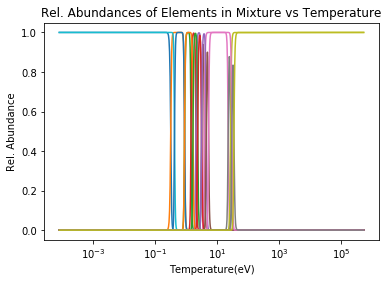

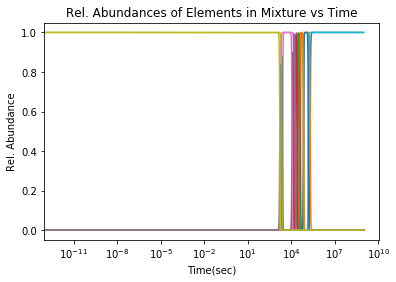

(2198, 9)
(2198, 10)


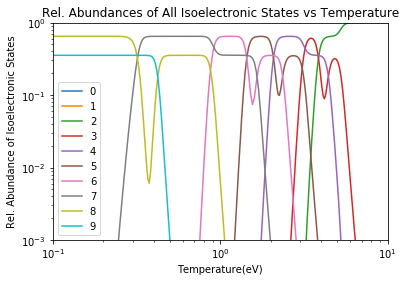

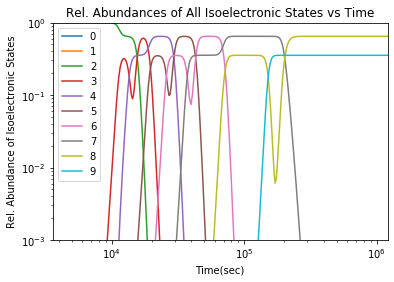

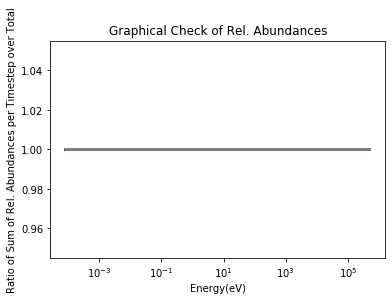

This calculation took 4.390625  sec to graph


In [8]:
#Call to function to generate data. Also, calculate time it takes.

time_start = process_time()
YI,bad,Ye_free,Ye_bound,Ye_f_Mid = abundance_calculation([8,9])
time_elapsed = (process_time() - time_start)
print("This calculation took",time_elapsed,' sec')
plotter(YI)

In [17]:
#Testing logic for summing up charge state abundances using above test calculation
charge_abundances = [] 

for i in range(np.shape(YI[-1])[1]):
    specific = np.zeros(len(time))
    for j in range(0,2):
        if i < np.shape(YI[j])[1]:
            #print(i)
            specific+=YI[j][:,i]
    charge_abundances.append(specific)
#pd.DataFrame(charge_abundances[0])

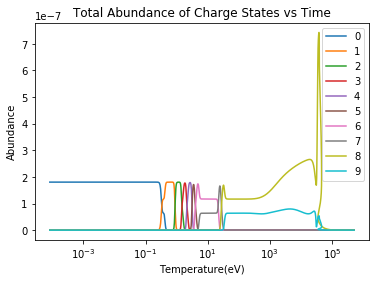

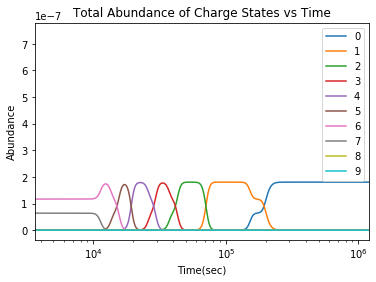

In [49]:
#PLotting of total ionization state abundances vs time
for i in range(len(charge_abundances)):
    plt.semilogx(kbEvpGK*np.array(full_temp),charge_abundances[i],label = i)
    plt.xlabel("Temperature(eV)")
    plt.ylabel("Abundance")
    plt.title('Total Abundance of Charge States vs Time')
plt.legend()
plt.show()

for i in range(len(charge_abundances)):
    plt.semilogx(np.array(time),charge_abundances[i],label = i)
    plt.xlabel("Time(sec)")
    plt.ylabel("Abundance")
    plt.title('Total Abundance of Charge States vs Time')
    plt.xlim([3600,1.21e+6])
plt.legend()

In [50]:
#Saving Data as .txt files
time_start = process_time()
YI,bad,Ye_free,Ye_bound,Ye_f_Mid,abundance_using_Ye_tot = abundance_calculation(np.arange(1,104,1))
time_elapsed = (process_time() - time_start)
print("This calculation took",time_elapsed,' sec')

with open("bad_testing.txt", 'wb') as fp:
        pickle.dump(YI, fp)
        
with open("bad_array.txt", 'wb') as fp:
        pickle.dump(bad, fp)
        
with open("Ye_free.txt", 'wb') as fp:
        pickle.dump(Ye_free, fp)
        
with open("Ye_bound.txt", 'wb') as fp:
        pickle.dump(Ye_bound, fp)

with open("Ye_f_Mid.txt","wb") as fp:
    pickle.dump(Ye_f_Mid,fp)    

This calculation took 184.140625  sec


In [9]:
#Loading in the files
with open("bad_testing.txt", "rb") as fp:   # Unpickling
      YI = pickle.load(fp)
        
with open("bad_array.txt", "rb") as fp:   # Unpickling
      bad = pickle.load(fp)

with open("Ye_free.txt", "rb") as fp:   # Unpickling
      Ye_free = pickle.load(fp)

with open("Ye_bound.txt", "rb") as fp:   # Unpickling
      Ye_bound = pickle.load(fp)
        
with open("Ye_f_Mid.txt","rb") as fp:
      Ye_f_Mid = pickle.load(fp)  

#elemental,potentials = initialization(np.arange(1,104,1))

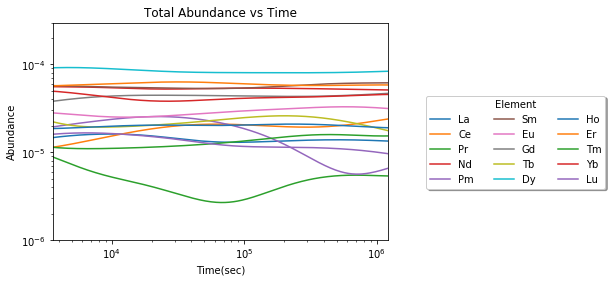

In [52]:
#PLotting elemental lanthanide abundances
lanthanide_names = ['La','Ce','Pr','Nd','Pm','Sm','Eu','Gd','Tb','Dy','Ho','Er','Tm','Yb','Lu']
for i in range(56,71):
    plt.loglog(time,elemental[i],label = lanthanide_names[i-56])
    plt.xlim(3600,1209600)
    plt.ylim(1e-6,3e-4)
    plt.title('Total Abundance vs Time')
    plt.xlabel('Time(sec)')
    plt.ylabel('Abundance')
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.45),shadow = True,fancybox = True,title = 'Element',ncol = 3)

In [53]:
time[-182] #index -182 or (2198-182) is the index corresponding to about 2 weeks
two_weeks_index = -182

In [54]:
#ordering of lanthanides by timestep

#lanthanide_names = ['La','Ce','Pr','Nd','Pm','Sm','Eu','Gd','Tb','Dy','Ho','Er','Tm','Yb','Lu']
ranking = []
for i in range(len(elemental[0])):
    values = dict()
    for j in range(56,71):
        values[j] = elemental[j,i]
    ranking.append(list(dict(sorted(values.items(), key=lambda x: x[1])).keys()))

ranking_names = []
for i in ranking:
    subname = []
    for j in i:
        subname.append(lanthanide_names[j-56])
    ranking_names.append(subname)

print(ranking_names[two_weeks_index])
print(ranking[two_weeks_index])

['Pr', 'Pm', 'Lu', 'La', 'Tm', 'Tb', 'Ho', 'Ce', 'Eu', 'Yb', 'Gd', 'Nd', 'Er', 'Sm', 'Dy']
[58, 60, 70, 56, 68, 64, 66, 57, 62, 69, 63, 59, 67, 61, 65]


In [55]:
ranking_names[0]

['Lu',
 'Yb',
 'Tm',
 'Er',
 'Ho',
 'Dy',
 'Tb',
 'Gd',
 'Eu',
 'Sm',
 'Pm',
 'Nd',
 'Pr',
 'Ce',
 'La']

C:\Users\prana\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


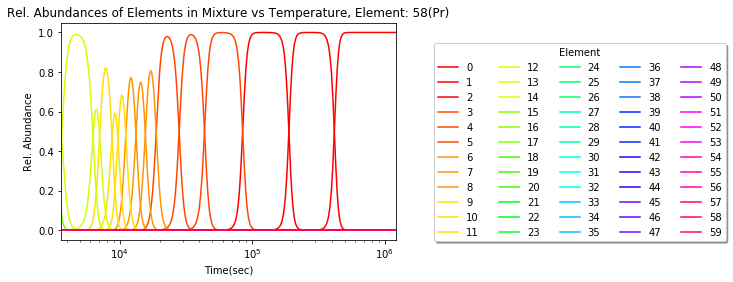

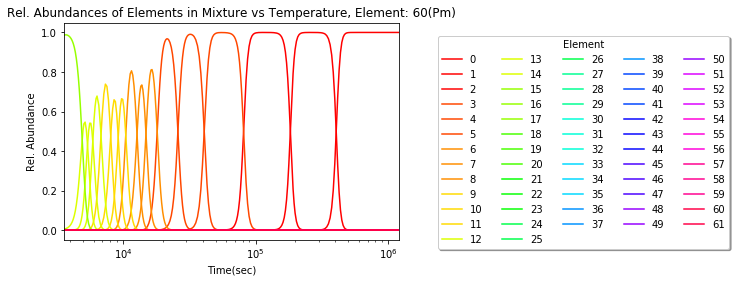

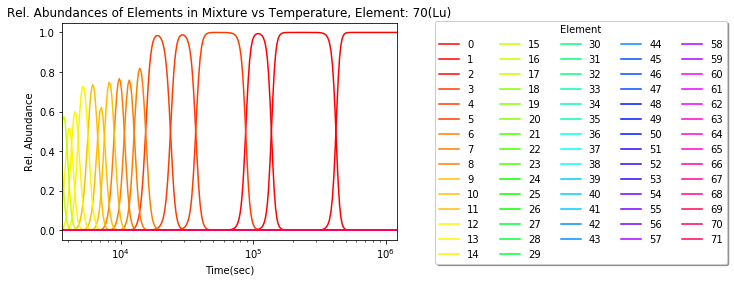

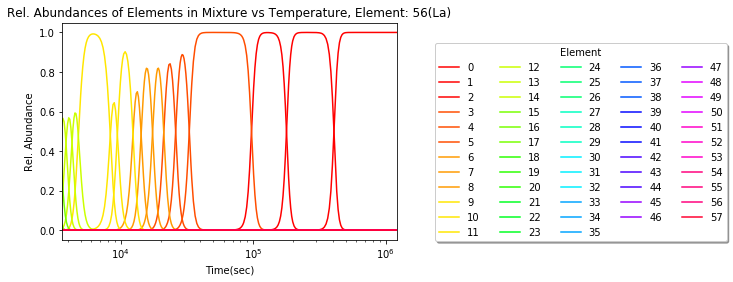

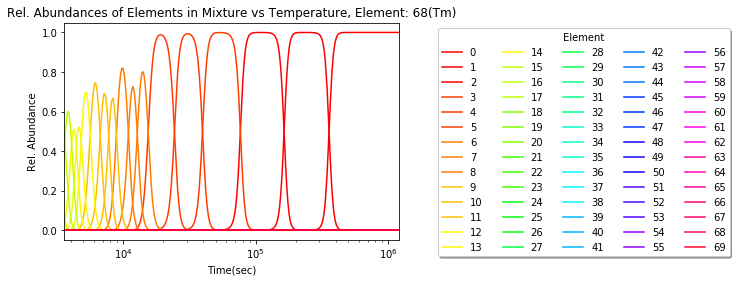

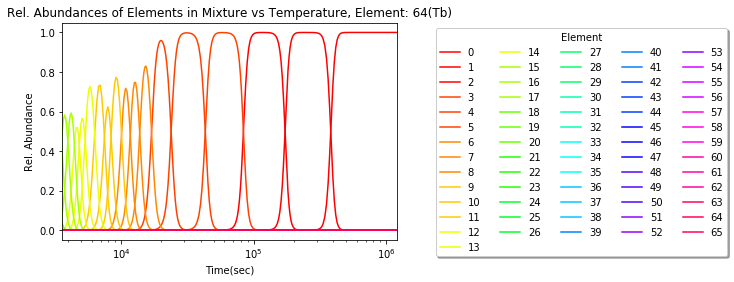

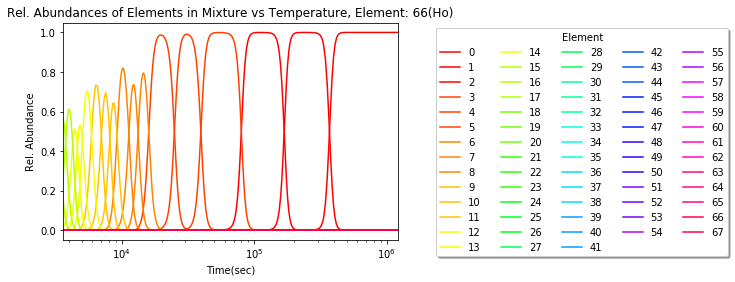

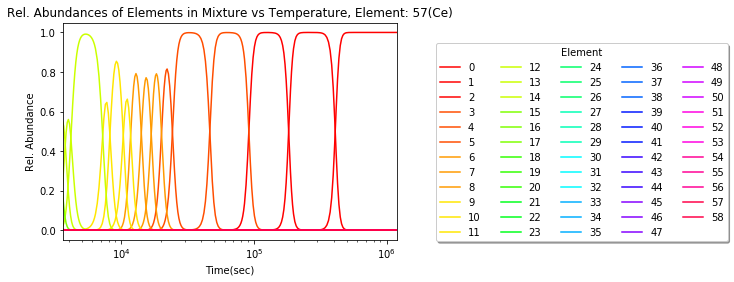

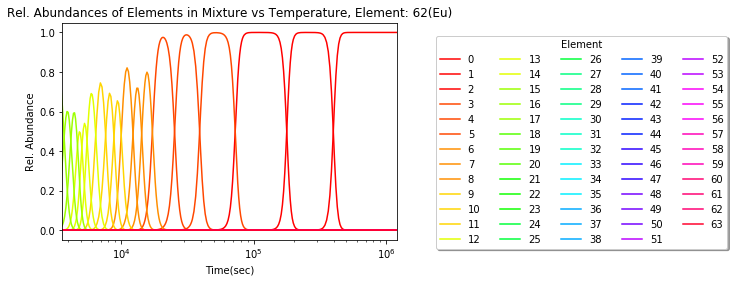

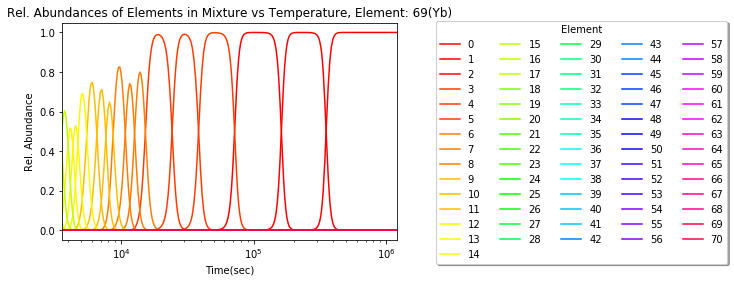

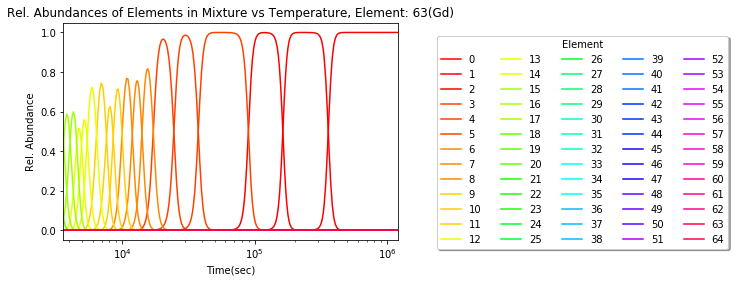

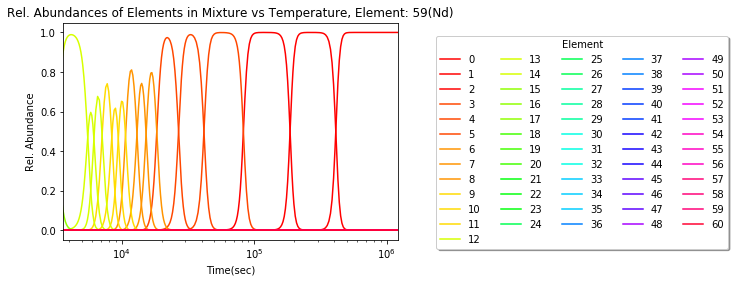

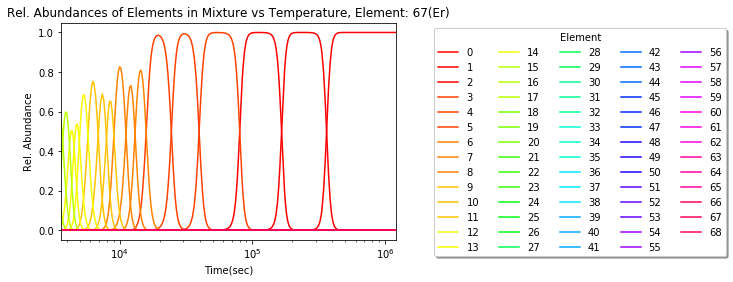

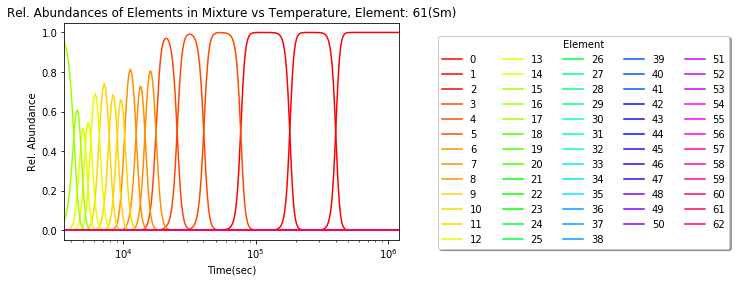

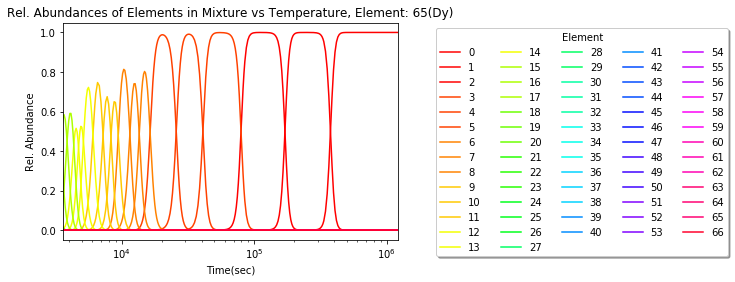

In [56]:
#Plotting charge state abundances for each of the lanthanides based on ordering of elemental lanthanide abundance
#at the two weeks time index

cm = plt.get_cmap('hsv') #Convenient color map
for i in ranking[two_weeks_index]:
    Y = YI[i]
    #Temperature
    Ytot = np.sum(Y,1)
    n = len(Y[0])
    for j in range(len(Y[0])):
        plt.semilogx(np.array(time),(Y[:,j])/Ytot,label = j,color = cm(j//3*3.0/n))
        plt.xlim(3600,1209600)
        plt.xlabel("Time(sec)")
        plt.ylabel("Rel. Abundance")
        
        title = "Rel. Abundances of Elements in Mixture vs Temperature, Element: " + str(i) + '(' + ranking_names[two_weeks_index][ranking[two_weeks_index].index(i)] + ')'     
        
        plt.title(title)
        plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.45),shadow = True,fancybox = True,title = 'Element',ncol = 5)
    plt.show()

In [87]:
#We must be careful with how we choose which abundances to consider. I am only plotting the charge state abundances of Lanth
#Considering that, only go from element 57 - 71, which means we need to consider index 56 to 70 only.
charge_abundances = [] 

for i in range(np.shape(YI[70])[1]):
    specific = np.zeros((len(time)))
    for j in range(56,71):
        if i < np.shape(YI[j])[1]:
            #print(i)
            specific+=YI[j][:,i]
    charge_abundances.append(specific)
pd.DataFrame(charge_abundances[0])

,0
0,9.688585e-68
1,9.688585e-68
2,9.688585e-68
3,9.688585e-68
4,9.688586e-68
5,9.688586e-68
6,9.688587e-68
7,9.688588e-68
8,9.688591e-68
9,9.688597e-68


In [33]:
#PLotting total charge state abundances vs temp and time. Just lanthanides
for i in range(len(charge_abundances)):
    plt.semilogx(kbEvpGK*np.array(full_temp),charge_abundances[i],label = i)
    plt.xlabel("Temperature(eV)")
    plt.ylabel("Abundance")
    plt.title('Total Abundance of Ionization States vs Time:Lanthanides')
#plt.legend()
plt.show()

n = 20
cm = plt.get_cmap('hsv') #Using prism highlights groups of 3. very useful. same with hsv

for i in range(0,n,1):
    plt.semilogx(np.array(time),charge_abundances[i],label = i,color = cm(i//3*3.0/n))
    plt.xlabel("Time(sec)")
    plt.ylabel("Abundance")
    plt.title('Total Abundance of Ionization States vs Time:Lanthanides')
    plt.xlim([3600,1.21e+6])
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5),shadow = True,fancybox = True,title = 'ionization state',ncol = 5)

NameError: name 'charge_abundances' is not defined

In [34]:
#Calculating charge state abundances for actinides alone
charge_abundances_act = [] 

for i in range(np.shape(YI[102])[1]):
    specific = np.zeros((len(time)))
    for j in range(89,103):
        if i < np.shape(YI[j])[1]:
            #print(i)
            specific+=YI[j][:,i]
    charge_abundances_act.append(specific)


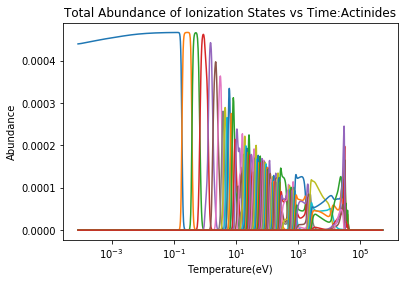

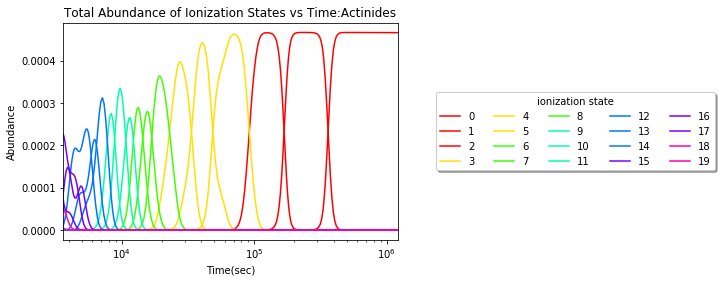

In [35]:
#PLotting total charge state abundances vs temp and time. Just Actinidies
#Weird to me that the actinide abundance perpetually decreases over time? atleast the charge state, I mean?
for i in range(len(charge_abundances_act)):
    plt.semilogx(kbEvpGK*np.array(full_temp),charge_abundances_act[i],label = i)
    plt.xlabel("Temperature(eV)")
    plt.ylabel("Abundance")
    plt.title('Total Abundance of Ionization States vs Time:Actinides')
#plt.legend()
plt.show()

n = 20
cm = plt.get_cmap('hsv') #Using prism highlights groups of 3. very useful. same with hsv

for i in range(0,n,1):
    plt.semilogx(np.array(time),charge_abundances_act[i],label = i,color = cm(i//3*3.0/n))
    plt.xlabel("Time(sec)")
    plt.ylabel("Abundance")
    plt.title('Total Abundance of Ionization States vs Time:Actinides')
    plt.xlim([3600,1.21e+6])
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5),shadow = True,fancybox = True,title = 'ionization state',ncol = 5)

In [36]:
#Calculating charge state abundances across all the elements
charge_abundances_all = [] 

for i in range(np.shape(YI[102])[1]):
    specific = np.zeros((len(time)))
    for j in range(0,103):
        if i < np.shape(YI[j])[1]:
            #print(i)
            specific+=YI[j][:,i]
    charge_abundances_all.append(specific)


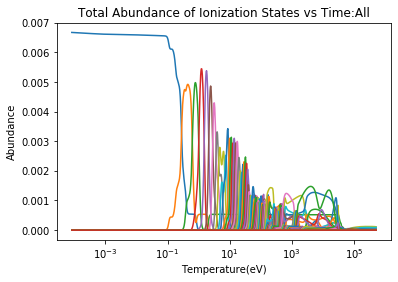

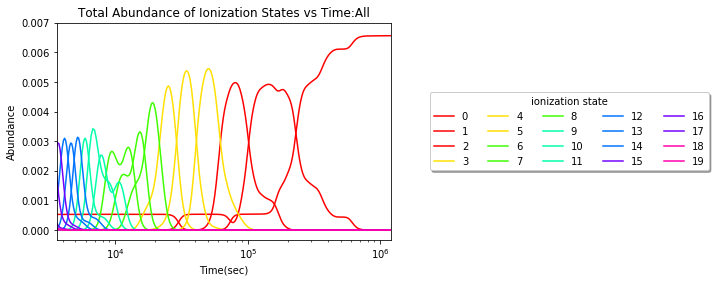

In [37]:
#PLotting total charge state abundances vs temp and time. All elements
for i in range(len(charge_abundances_all)):
    plt.semilogx(kbEvpGK*np.array(full_temp),charge_abundances_all[i],label = i)
    plt.xlabel("Temperature(eV)")
    plt.ylabel("Abundance")
    plt.title('Total Abundance of Ionization States vs Time:All')
#plt.legend()
plt.show()

n = 20
cm = plt.get_cmap('hsv') #Using prism highlights groups of 3. very useful. same with hsv

for i in range(0,n,1):
    plt.semilogx(np.array(time),charge_abundances_all[i],label = i,color = cm(i//3*3.0/n))
    plt.xlabel("Time(sec)")
    plt.ylabel("Abundance")
    plt.title('Total Abundance of Ionization States vs Time:All')
    plt.xlim([3600,1.21e+6])
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5),shadow = True,fancybox = True,title = 'ionization state',ncol = 5)

In [40]:
#Now, I want to calculate the abundances for the isoelectronic states
#Note that isoelectronic states have similar electron configurations since they all have the same number of electrons there
zmin = 57
zmax = 71
isoelectronic_abundances = []
for i in range(np.shape(YI[zmax-1])[1]):
    '''This for loop has to have 72 values since there are 71 cases with electrons and then the fully ionized case'''
    specific = np.zeros(len(time))
    for j in range(zmin-1,zmax): #Elements 57 to 71 means indices of 56 to 70
        if i <= np.shape(YI[j])[1]:
            specific+=YI[j][:,np.shape(YI[j])[1]-1-i]
    isoelectronic_abundances.append(specific) 

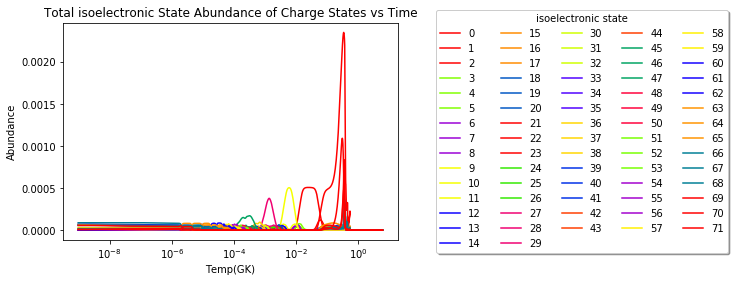

In [42]:
#Plotting of isoelectronic states vs time
n = 72
cm = plt.get_cmap('prism') #Using prism highlights groups of 3. very useful. same with hsv

for i in range(0,n,1):
    plt.semilogx(np.array(full_temp),isoelectronic_abundances[i],label = i,color = cm(i//3*3.0/n))
    plt.xlabel("Temp(GK)")
    plt.ylabel("Abundance")
    plt.title('Total isoelectronic State Abundance of Charge States vs Time')
    #plt.xlim([3600,1.21e+6])
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5),shadow = True,fancybox = True,title = 'isoelectronic state',ncol = 5)

In [43]:
from saha_Luke_isoelectronic import SkyNetIonization 
fname = 'SkyNet_r-process.h5'
run = SkyNetIonization(fname, calculateYeFree = True)
YI = run.GetIsoElectronicAbundances(57,71)


C:\Users\prana\Documents\Research\R-process_Mergers\Abundance_Calculations\Total Charge State Abundances\saha_Luke_isoelectronic.py:93: RuntimeWarning: divide by zero encountered in log
  fLow = np.log(GetYefContribution(Ytot, T9, rho, lnYefLow, xi)) - lnYefLow
C:\Users\prana\Documents\Research\R-process_Mergers\Abundance_Calculations\Total Charge State Abundances\saha_Luke_isoelectronic.py:94: RuntimeWarning: divide by zero encountered in log
  fHi = np.log(GetYefContribution(Ytot, T9, rho, lnYefHi, xi)) - lnYefHi
C:\Users\prana\Documents\Research\R-process_Mergers\Abundance_Calculations\Total Charge State Abundances\saha_Luke_isoelectronic.py:104: RuntimeWarning: divide by zero encountered in log
  fMid = np.log(GetYefContribution(Ytot, T9, rho, lnYefMid, xi)) - lnYefMid


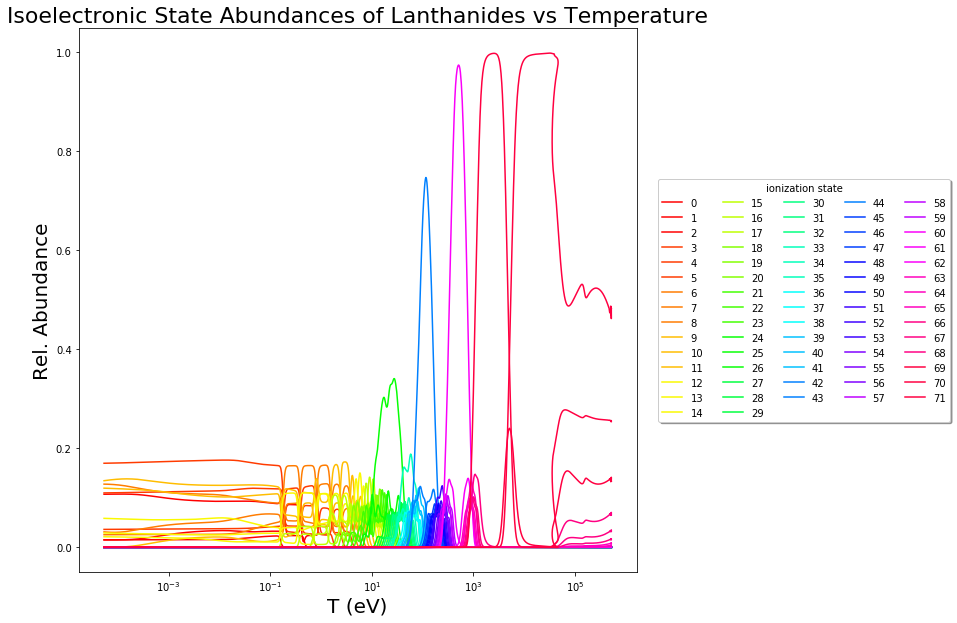

(2198, 72)

In [44]:
#Luke's plot of isoelectronic state abundances
YRangeTot = np.sum(YI, 1) # Get the total abundance at each time to normalize

plt.figure(figsize=(10,10))

n = 71
cm = plt.get_cmap('hsv') #Using prism highlights groups of 3. very useful. same with hsv
# Plot up a comparison of the fixed YeFree solution and the self-consistent YeFree solution 
for i in range(len(YI[0,:])): 
    plt.plot(kbEvpGK*run.T9, YI[:,i]/YRangeTot,label = i,color = cm(i//3*3.0/n))
plt.legend()

plt.yscale('linear')
plt.xscale('log')
plt.xlabel('T (eV)', fontsize=20)
plt.ylabel('Rel. Abundance', fontsize=20)
plt.title('Isoelectronic State Abundances of Lanthanides vs Temperature',fontsize = 22)
#plt.ylim([1.e-6, 1.0])
#plt.xlim([1.e-7, 0.5])
plt.legend(loc='center left', bbox_to_anchor=(1.03, 0.5),shadow = True,fancybox = True,title = 'ionization state',ncol = 5)
plt.show()
np.shape(YI)

In [27]:
#Check the amount of isoelectronic states that are above a certain threshold at late times/ low temps
#Make a plot of isoelectronic state abundances vs temp that are above thershold
threshold = 10**-6
counter = []
for ion in range(len(YI[-1])):
    specific = []
    for time in range(2050,2198):
        if YI[time,ion] >= threshold:
            specific.append(1)
        else:
            specific.append(0)
    counter.append(specific)

In [28]:
YI[2197,0]

7.74012813697295e-06

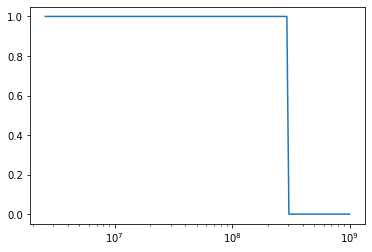

In [29]:
#Plot showing how important each isoelectronic state is at different times
plt.semilogx(run.time[2050:2198],counter[10],label = i)

Text(0.5, 1.0, 'Number of Contributing Isoelectronic States to the Lines vs Temperature')

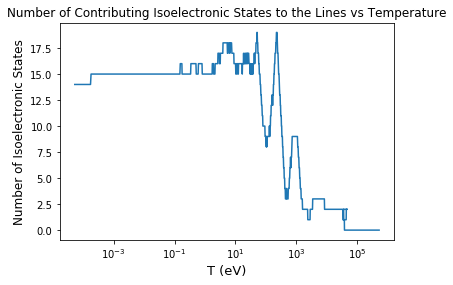

In [45]:
#Plot that shows the number of important isoelectronic states to the lines vs temperature. Must be above 1e-6
YI = run.GetIsoElectronicAbundances(57,71)
abundanceThreshold = 1.e-6
NContribute = np.count_nonzero(np.where(YI > abundanceThreshold, np.ones(YI.shape), np.zeros(YI.shape)), 1)
plt.semilogx(kbEvpGK*run.T9, NContribute)
plt.xlabel('T (eV)',fontsize = 13)
plt.ylabel('Number of Isoelectronic States',fontsize = 12)
plt.title("Number of Contributing Isoelectronic States to the Lines vs Temperature")

In [46]:
print(np.shape(NContribute))

(2198,)
